In [1]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tqdm import tqdm

from adj import main, combine_graph_dict
from train import train_model
from utils import mclust_R, fix_seed

In [2]:
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score
from sklearn.metrics import v_measure_score as v_score
from utils import compute_PAS, compute_CHAOS
from sklearn.decomposition import PCA

In [3]:
fix_seed(1)

In [4]:
data_root = Path('../data/DLPFC')

proj_list = [
    '151507', '151508', '151509', '151510' 
]

In [5]:
for proj_name in tqdm(proj_list):
    adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name+"_filtered_feature_bc_matrix.h5")
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    graph_dict_tmp = main(adata_tmp, adj_cons_by='coordinate', distType='KNN', k_cutoff=8, rad_cutoff=250)
    
    ##### Load layer_guess label, if have
    df_label = pd.read_csv(data_root / proj_name / 'manual_annotations.txt', sep='\t', header=None, index_col=0)
    df_label.columns = ['layer_guess']
    adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    #adata_tmp= adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]
    
    if proj_name == proj_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name
    
        adata = adata.concatenate(adata_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name

  0%|          | 0/4 [00:00<?, ?it/s]

------Calculating spatial graph...


 25%|██▌       | 1/4 [00:01<00:03,  1.01s/it]

The graph contains 33808 edges, 4226 cells.
8.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 35072 edges, 4384 cells.
8.0000 neighbors per cell on average.


 50%|█████     | 2/4 [00:02<00:02,  1.22s/it]

------Calculating spatial graph...
The graph contains 38312 edges, 4789 cells.
8.0000 neighbors per cell on average.


 75%|███████▌  | 3/4 [00:04<00:01,  1.55s/it]

------Calculating spatial graph...
The graph contains 37072 edges, 4634 cells.
8.0000 neighbors per cell on average.


100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [7]:
sedr_net = train_model(adata, graph_dict, pre_epochs=500 ,epochs=1000, mask_rate=0.2)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(num_aggre=1)
else:
    sedr_net.train_without_dec()

Epoch 499 total loss=19.535: 100%|██████████ [ time left: 00:00 ]    
Epoch 999 total loss=7.795 recon loss=7.009 kl loss=0.051 tri loss=0.273 : |           [ time left: 00:00 ]      


In [8]:
sedr_feat, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

In [9]:
mclust_R(adata, num_cluster=7, used_obsm='SEDR')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 18033 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'layer_guess', 'proj_name', 'batch', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'Tri_SEDR', 'SEDR'
    layers: 'count'

In [10]:
#adata.write("Ours_DLPFC_151507")

In [11]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

total ARI:0.47773184529022966
151507 ARI:0.4815320756129149
151508 ARI:0.47287303060532365
151509 ARI:0.481894450571278
151510 ARI:0.47612058603088064


In [12]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# NMI = nmi_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
# print(f"total NMI:{NMI}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     NMI = nmi_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
#     print(f"{name} NMI:{NMI}")

In [13]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# HOM = hom_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
# print(f"total HOM:{HOM}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     HOM = hom_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
#     print(f"{name} HOM:{HOM}")

In [14]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# COM = com_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
# print(f"total COM:{COM}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     COM = com_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
#     print(f"{name} COM:{COM}")

In [15]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
NMI = nmi_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total NMI:{NMI}")
AMI = ami_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total AMI:{AMI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    AMI = ami_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} ACC:{ACC}")

total NMI:0.6393912750366295
total AMI:0.6391851704218207
151507 ACC:0.6550258272491317
151508 ACC:0.6407213227094318
151509 ACC:0.665350812934868
151510 ACC:0.6496869371487073


In [16]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# CHAOS = compute_CHAOS(sub_adata, f'mclust')
# print(f"total CHAOS:{CHAOS}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     CHAOS = compute_CHAOS(sub_adata_tmp, f'mclust')
#     print(f"{CHAOS}")

In [17]:
# sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# PAS = compute_PAS(sub_adata, f'mclust')
# print(f"total PAS:{PAS}")
# for name in proj_list:
#     sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
#     PAS = compute_PAS(sub_adata_tmp, f'mclust')
#     print(f"{PAS}")

In [18]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
HOM = hom_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total HOM:{HOM}")
COM = com_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    COM = com_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    V =  2 * ((HOM * COM) / (HOM + COM))
    print(f"{name} V:{V}")

total HOM:0.6456909640684214
total COM:0.6332133241975819
151507 V:0.6554375920873851
151508 V:0.6411400117682353
151509 V:0.6657286310517512
151510 V:0.6501067197249165


2.800508257892237
1.2875798623496548


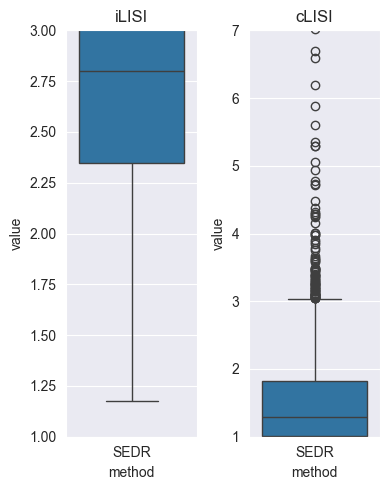

In [19]:
import harmonypy as hm

iLISI = hm.compute_lisi(adata.obsm['SEDR'], adata.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata.obsm['SEDR'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]
df_iLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

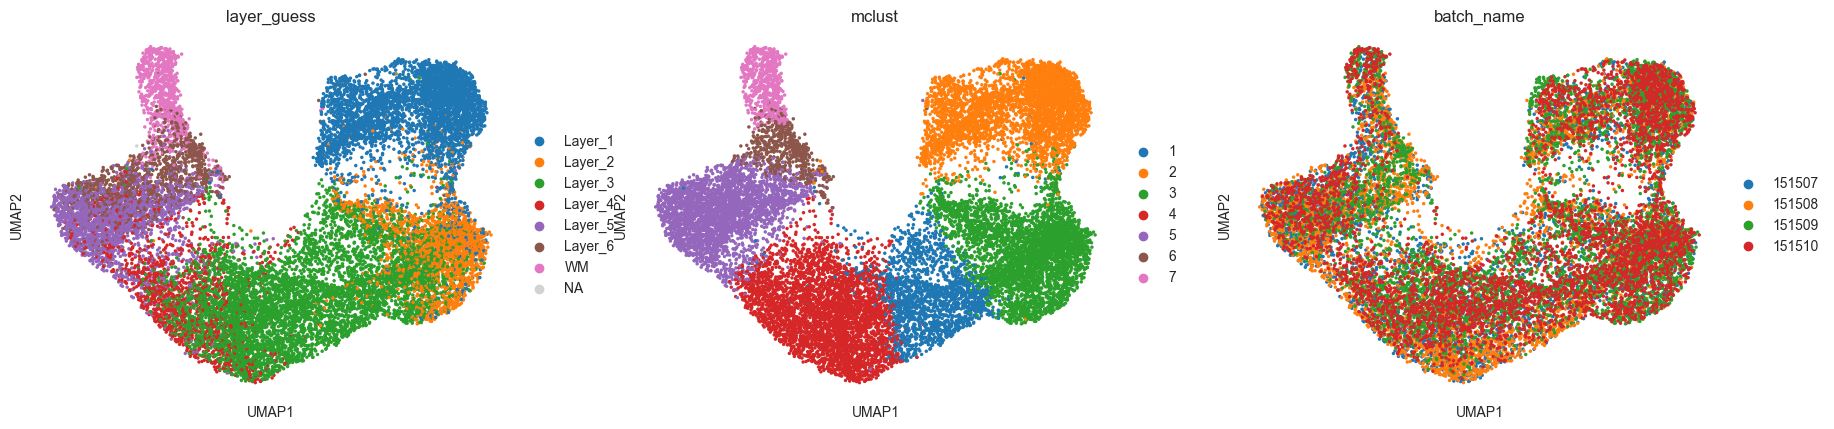

In [20]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色
# plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
# plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

# %%
sc.pp.neighbors(adata, use_rep='SEDR', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=True, size=25, save=False)

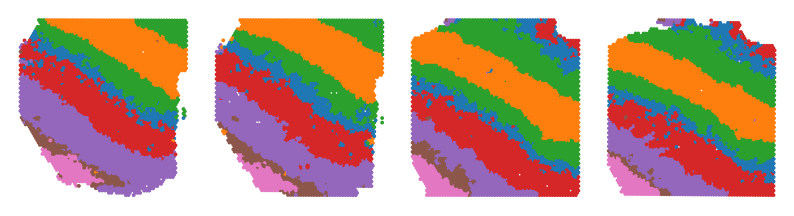

In [21]:
Batch_list = []
for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
# for bb in range(len(proj_list)):
#     ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))
fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=spot_size)
    # _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)
plt.show()